In [1]:
import casacore.tables as pt

import dp3
import numpy as np
import astropy.time as ast
import scipy
from scipy.io import loadmat
import lofarantpos.db
import matplotlib.pyplot as plt

In [2]:
#1
ms_name = 'tbb_dat19.ms'
ms_desc = pt.required_ms_desc()
ms_desc["DATA"] = pt.makearrcoldesc(
    "DATA", 0.0, valuetype="complex", ndim=2, shape=[1, 4]
)["desc"]
for colname in (
    "ANTENNA1",
    "ARRAY_ID",
    "DATA_DESC_ID",
    "EXPOSURE",
    "FEED1",
    "FEED2",
    "FIELD_ID",
    "FLAG_CATEGORY",
    "FLAG_ROW",
    "INTERVAL",
    "OBSERVATION_ID",
    "PROCESSOR_ID",
    "SCAN_NUMBER",
    "SIGMA",
    "STATE_ID",
    "TIME",
    "TIME_CENTROID",
):
    ms_desc[colname]["dataManagerType"] = "IncrementalStMan"
    ms_desc[colname]["dataManagerGroup"] = "IncrementalStMan"

In [3]:
!rm -rf ms_name
ms = pt.default_ms(ms_name, tabdesc=ms_desc)

ms.close()


In [4]:
#pt.taql("insert into new.MS::ANTENNA SET NAME='CS0021'")
pt.taql(
    "insert into tbb_dat19.ms::FIELD set NAME='pointing', PHASE_DIR=[[0,0,0]], DELAY_DIR=[[0,0,0]], REFERENCE_DIR=[[0,0,0]]"
)
####pt.taql("insert into new.MS set ANTENNA1=0, ANTENNA2=0, DATA=0, INTERVAL=1.0")
pt.taql("INSERT INTO tbb_dat19.ms::OBSERVATION SET TELESCOPE_NAME='LOFAR'")
pt.taql(
    "INSERT INTO tbb_dat19.ms::SPECTRAL_WINDOW SET CHAN_FREQ=[67.8]MHz,"
    + "CHAN_WIDTH=[0.195]MHz, "
    + "RESOLUTION=[0.195]MHz, "
    + "EFFECTIVE_BW=[0.195]MHz, NUM_CHAN=1, REF_FREQUENCY=67.8MHz, "
    + "TOTAL_BANDWIDTH = 0.195MHz"
)
pt.taql(
    "INSERT INTO tbb_dat19.ms::POLARIZATION SET CORR_TYPE=[9,10,11,12], CORR_PRODUCT=[[0,0],[0,1],[1,0],[1,1]], NUM_CORR=4"##CORR_TYPE=[9,10,11,13]
)##CORR_PRODUCT =[[0,0],[0,1],[1,0],[1,1]], NUM_CORR =4
pt.taql(
    "INSERT INTO tbb_dat19.ms::DATA_DESCRIPTION SET POLARIZATION_ID=0, SPECTRAL_WINDOW_ID=0"
);


In [5]:
#pt.taql("SELECT * FROM mon_test.ms::OBSERVATION")
import astropy.time as ast

# Create an astropy time object for the given datetime string
start_time = ast.Time("2022-03-23T21:12:34.762")
end_time = ast.Time("2022-03-23T21:12:35.762")
# Convert to MJD in seconds since the reference epoch
start_mjdseconds = start_time.mjd * 86400.0
end_mjdseconds = end_time.mjd * 86400.0
print("START TIME MJD in seconds: ", start_mjdseconds)
print("END TIME MJD in seconds: ", end_mjdseconds)

time_range = np.array((start_mjdseconds, end_mjdseconds))
time_range = time_range.reshape(1,2)
print(time_range)

START TIME MJD in seconds:  5154786754.762
END TIME MJD in seconds:  5154786755.762
[[5.15478675e+09 5.15478676e+09]]


In [6]:

t = pt.table(ms_name+'/OBSERVATION', readonly=False)
t.putcol("TIME_RANGE", time_range)
t.putcol("SCHEDULE_TYPE", "AARTFAAC")
t.putcol("TELESCOPE_NAME", "LOFAR")
#t.putcol("AARTFAAC_FLAG_WINDOW_SIZE",1)
#t.putcol("AARTFAAC_ANTENNA_TYPE","LBA")
#t.putcol("AARTFAAC_RCU_MODE",1)

t.close()


Successful read/write open of default-locked table tbb_dat19.ms/OBSERVATION: 9 columns, 1 rows


(288, 3)


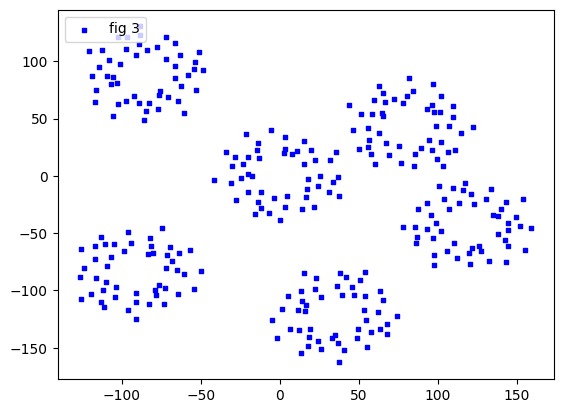

In [7]:
db = lofarantpos.db.LofarAntennaDatabase()

statname = ['CS002LBA', 'CS003LBA', 'CS004LBA', 'CS005LBA', 'CS006LBA', 'CS007LBA'];

Nstat=len(statname)
Nant=48
stref = []
for st in statname:
    strefi= db.phase_centres[st]
    stref.append(strefi)
    

stref= np.array(stref)
#print(stref)
#print(Nstat)
#print(Nant)
#db.antenna_pqr('RS210LBA')[:5]

(r, c) =stref.shape

abs_antpos=np.zeros((48*6,3))

for i in range(r):
    antposi= db.antenna_etrs(statname[i])[48:]
    #print(antpos)
  #  abs_antposi= antpos + stref[i]
    abs_antpos[48*i:48*(i+1),:]= antposi
    
statref_CS002= stref[0,:]
#print(statref_CS002)
statref_CS002rep = np.tile(statref_CS002, (48*6,1))
#print(statref_CS002rep)
#same variable as in matlab function ADS_superter_analysis.m 
rotmat = loadmat('rotmat.mat')
rotmat = np.array(rotmat['rotmat'])
#print(rotmat)
x = np.matmul(np.linalg.pinv(np.transpose(rotmat)),np.transpose(abs_antpos - statref_CS002rep))
x= np.transpose(x)
posITRF = np.array(x)
print(posITRF.shape)

antpos_etrs= np.array(abs_antpos)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x[:,0], x[:,1], s=10, c='b', marker="s", label='fig 3')
plt.legend(loc='upper left');
plt.show()
#print(antpos_etrs)

In [8]:
t = pt.table(ms_name+'/ANTENNA', readonly=False)
t.addrows(288)
t.putcol("POSITION", antpos_etrs)

t.close()

Successful read/write open of default-locked table tbb_dat19.ms/ANTENNA: 8 columns, 0 rows


In [9]:
pt.taql("SELECT * FROM tbb_dat19.ms/ANTENNA")

In [10]:
superterp_data = loadmat('superterp_data.mat')
covmat= superterp_data["covmat"]
print(covmat.shape)
print(covmat.dtype)
nr_ant = covmat.shape[0]
(ant1_idx, ant2_idx)= np.triu_indices(nr_ant)
uvw= antpos_etrs[ant1_idx,:] - antpos_etrs[ant2_idx,:]
print(uvw.shape)
nr_bl= nr_ant * (nr_ant+1)//2
x = covmat[np.triu_indices(nr_ant)].astype(np.complex64)#.reshape((nr_bl, 1, 1))
z = np.zeros((nr_bl,))
cov = np.column_stack((x, z, z, x))
(r, c) = cov.shape
dat_col = cov.reshape((r, 1, 4))
flag1=[False]*4
sigma1= np.repeat([[1]], 4, axis=1)
weight1 = np.repeat([[1]], 4, axis=1)
print(dat_col.shape)
print(weight1.shape)
print(flag1.shape)

(288, 288)
complex128


NameError: name 'antpos_etrs' is not defined

In [11]:
t = pt.table(ms_name, readonly=False)

t.addrows(nr_bl)

covmat[np.triu_indices(nr_ant)].astype(np.complex64).reshape((nr_bl, 1, 1)).shape

t.putcol("DATA", dat_col, startrow=0, nrow=nr_bl)
t.putcol("TIME", np.repeat(5154786754.762, nr_bl,axis=0), startrow=0, nrow=nr_bl)
t.putcol("TIME_CENTROID", np.repeat(5154786754.762,nr_bl,axis=0), startrow=0, nrow=nr_bl)
t.putcol("EXPOSURE", np.repeat(1,nr_bl,axis=0), startrow=0, nrow=nr_bl)
t.putcol("INTERVAL", np.repeat(1, nr_bl, axis=0), startrow=0, nrow=nr_bl)
t.putcol("FLAG",np.repeat([[flag1]], nr_bl,axis=0), startrow=0, nrow=nr_bl)
t.putcol("WEIGHT", np.repeat(weight1, nr_bl, axis=0), startrow=0, nrow=nr_bl)
t.putcol("SIGMA", np.repeat(sigma1,nr_bl,axis=0), startrow=0, nrow=nr_bl)
t.putcol("ANTENNA1", ant1_idx, startrow=0, nrow=nr_bl)
t.putcol("ANTENNA2", ant2_idx, startrow=0, nrow=nr_bl)
t.putcol("UVW", uvw, startrow=0, nrow=nr_bl)
t.close()

Successful read/write open of default-locked table tbb_dat19.ms: 22 columns, 0 rows


In [12]:
pt.taql("SELECT * FROM tbb_dat19.ms LIMIT 10")

In [13]:
parset = dp3.parameterset.ParameterSet()

parset.add("msin", "tbb_dat19.ms")
parset.add("msout", "tbb_dat19_out.ms")
parset.add("steps", "[]")
parset.add("out.overwrite", "True")

In [14]:
first_step = dp3.make_main_steps(parset)


In [15]:
first_step.set_info(dp3.DPInfo())
first_step.process(dp3.DPBuffer())

 copying info and subtables ...


True

Finished preparing output MS


In [3]:
pt.taql('SELECT * FROM a12-SB212-1sec-reference.ms/FIELD')

In [4]:
pt.taql("UPDATE tbb_dat19.ms::FIELD SET PHASE_DIR = [07h05m04.682, +052d45m48.456]")

RuntimeError: Error in TaQL command: 'using style Python UPDATE tbb_dat19.ms::FIELD SET PHASE_DIR = [07h05m04.682, +052d45m48.456]'
  Invalid Table operation: ArrayColumn::setShape: mismatch in #dim of array of column PHASE_DIR